In [1]:
# Import libraries

import numpy as np
import pandas as pd
from pandas_datareader import data
import plotly.express as px
import datetime
import plotly.graph_objects as go
import plotly.io as pio
from datetime import timedelta
from MCForecastTools import MCSimulation
from IPython.display import display

In [2]:
# Import variables 

%store -r stocks
%store -r benchmark
%store -r start_date
%store -r end_date
%store -r out_sample_days_held_back
%store -r theme
%store -r number_opt_porfolios
%store -r rf
%store -r number_simulation
%store -r years
%store -r init_investment
seed=42
np.random.seed(seed)
%store -r df
%store -r stock_returns
%store -r stock_returns_excl_ly


## Calculate Portfolio Weights using Sample/Sliced Dataframe

In [3]:
# Calculate Covariance matrix of the log stock returns. We use log as it produces marginally more accurate results.

cov_matrix_excl = stock_returns_excl_ly.apply(lambda x: np.log(1+x)).cov()
cov_matrix_excl

AMGN_Returns  IBM_Returns  MMM_Returns  TRV_Returns  WBA_Returns
AMGN_Returns      0.000287     0.000102     0.000114     0.000129     0.000122
IBM_Returns       0.000102     0.000230     0.000132     0.000145     0.000124
MMM_Returns       0.000114     0.000132     0.000223     0.000154     0.000128
TRV_Returns       0.000129     0.000145     0.000154     0.000343     0.000134
WBA_Returns       0.000122     0.000124     0.000128     0.000134     0.000345

In [4]:
# Calculate Correlation matrix of the log stock returns. We use log as it produces marginally more accurate results.

corr_matrix_excl = stock_returns_excl_ly.apply(lambda x: np.log(1+x)).corr()
corr_matrix_excl

AMGN_Returns  IBM_Returns  MMM_Returns  TRV_Returns  WBA_Returns
AMGN_Returns      1.000000     0.394914     0.450506     0.411388     0.386799
IBM_Returns       0.394914     1.000000     0.580687     0.516760     0.438500
MMM_Returns       0.450506     0.580687     1.000000     0.556028     0.461422
TRV_Returns       0.411388     0.516760     0.556028     1.000000     0.389539
WBA_Returns       0.386799     0.438500     0.461422     0.389539     1.000000

In [5]:
# Annual Returns
# CAGR for individual companies 

dt = pd.to_datetime(start_date, format='%Y/%m/%d')
dt2 = pd.to_datetime(stock_returns_excl_ly.index[-1], format='%Y-%m-%d')

yrs = ((dt2-dt).days)/365
%store yrs

annual_returns_excl = stock_returns_excl_ly.apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/yrs) - 1
annual_returns_excl

Stored 'yrs' (float)


AMGN_Returns    0.137513
IBM_Returns     0.054677
MMM_Returns     0.086271
TRV_Returns     0.108074
WBA_Returns     0.040670
Name: 2021-10-01 00:00:00, dtype: float64

In [6]:
# Standard Deviation
# Volatility is given by the annual standard deviation. We multiply by 252 because there are 252 trading days/year. Also
# We will use the log of the stock returns in our calculation as it produces mrginally more accurate results.

annual_std_dev_excl = stock_returns_excl_ly.apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
annual_std_dev_excl

AMGN_Returns    0.269144
IBM_Returns     0.240971
MMM_Returns     0.236854
TRV_Returns     0.294168
WBA_Returns     0.294901
dtype: float64

In [7]:
#Concatenate the annual returns and standard deviation dataframes

risk_return_excl = pd.concat([annual_returns_excl, annual_std_dev_excl], axis=1) # Creating a table for visualising returns and volatility of assets
risk_return_excl.columns = ['Returns', 'Volatility']
risk_return_excl

Returns  Volatility
AMGN_Returns  0.137513    0.269144
IBM_Returns   0.054677    0.240971
MMM_Returns   0.086271    0.236854
TRV_Returns   0.108074    0.294168
WBA_Returns   0.040670    0.294901

In [8]:
# Setup lists to hold portfolio weights, returns and volatility

p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = number_opt_porfolios

In [9]:
# Calculate Portfolio weights for num_portfolios
np.random.seed(seed)

for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, annual_returns_excl) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix_excl.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(252) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [10]:
# Insert the stock weights that correspond to the respective portfolio return and volatility

data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [11]:
# Create portfolios dataframe to hold the portfolio weights of stocks, and portfolio return, volatility and sharpe ratio

portfolios_sample  = pd.DataFrame(data)

portfolios_sample['Sharpe'] = (portfolios_sample['Returns']-rf)/portfolios_sample['Volatility']

portfolios_sample.head() # Dataframe of the 10000 portfolios created

Returns  Volatility  AMGN weight  IBM weight  MMM weight  TRV weight  \
0  0.084526    0.202026     0.133197    0.338101    0.260318    0.212900   
1  0.080820    0.212218     0.065285    0.024308    0.362501    0.251571   
2  0.071274    0.205947     0.009284    0.437468    0.375464    0.095773   
3  0.083922    0.203918     0.105673    0.175297    0.302353    0.248877   
4  0.093847    0.205966     0.327909    0.074759    0.156568    0.196343   

   WBA weight    Sharpe  
0    0.055485  0.368893  
1    0.296334  0.333713  
2    0.082010  0.297521  
3    0.167800  0.362508  
4    0.244421  0.407089

In [12]:
# Plot efficient frontier

#px.scatter(portfolios, x='Volatility', y='Returns', color='Sharpe', title='Portfolio Efficient Frontier',
#          marginal_y='box')

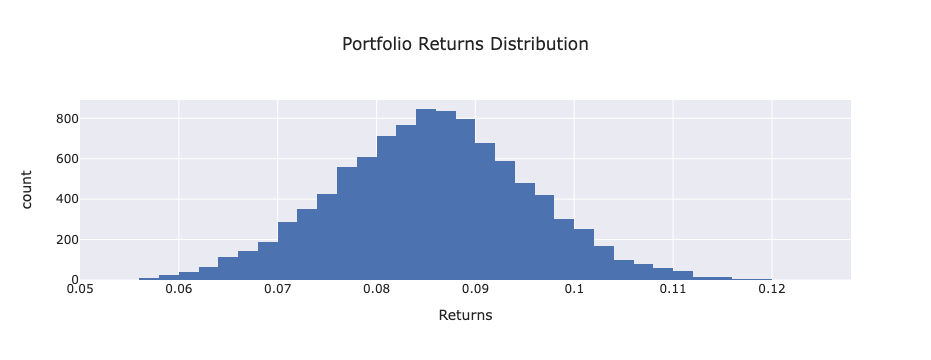

In [13]:
# Plot Portfolio Return Distribution

px.histogram(portfolios_sample, x='Returns', nbins=50, title='Portfolio Returns Distribution', template=theme)

In [14]:
# Finding the optimal portfolio

optimal_risky_port_sample = portfolios_sample.iloc[(portfolios_sample['Sharpe']).idxmax()]
%store optimal_risky_port_sample


Stored 'optimal_risky_port_sample' (Series)


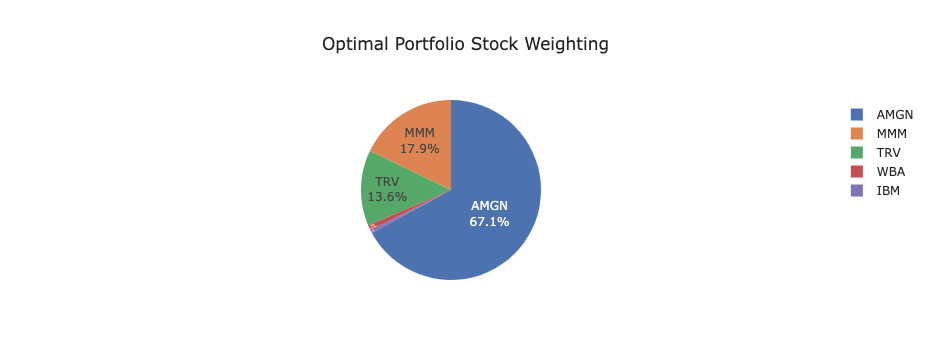

In [15]:
# Pie Chart of optimal portfolio stock weightings

opt_port_df = pd.DataFrame(data={'Stocks': df.columns.tolist(), 'Weight': optimal_risky_port_sample[2:-1].values})

fig = px.pie(opt_port_df, values='Weight', names='Stocks',
             title='Optimal Portfolio Stock Weighting',
             template=theme
            )
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

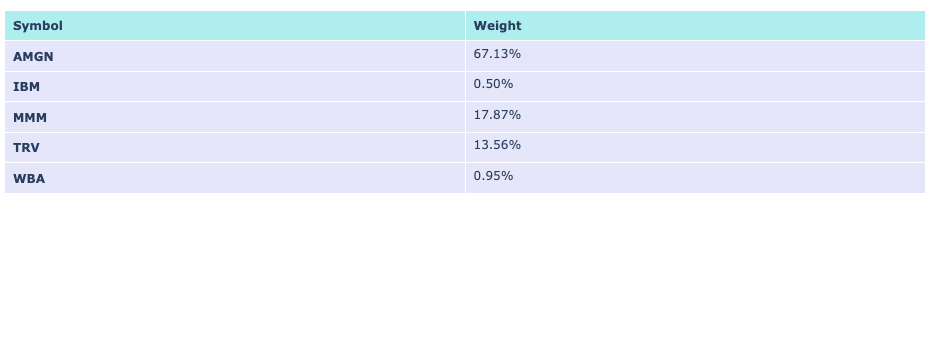

In [16]:
# Optimal Portfolio Stock Weights Table - Sample Data

head = ['<b>Symbol<b>', '<b>Weight<b>']

labels =[]

for stock in opt_port_df['Stocks'].tolist():
    txt='<b>'+stock+'<b>'
    labels.append(txt)
    
wght =[]
    
for weight in opt_port_df['Weight'].tolist():
    w = '{:.2%}'.format(weight)
    wght.append(w)

    
fig = go.Figure(data=[go.Table(
    header=dict(values=head,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[labels, wght],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(margin=dict(l=5, r=5, b=0,t=10))

fig.show()

In [17]:
# create an optimal portfolio dataframe

optimal_port_df = pd.DataFrame(data={'Returns': optimal_risky_port_sample[0], 'Volatility': optimal_risky_port_sample[1]}, index=[0])
#optimal_port_df

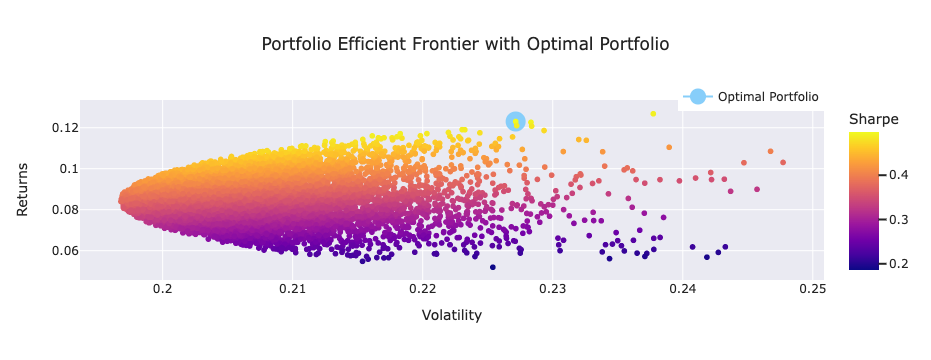

In [18]:
# Plot efficient frontier with optimal portfolio

fig = px.scatter(portfolios_sample, x='Volatility', y='Returns', color='Sharpe', title='Portfolio Efficient Frontier with Optimal Portfolio')
fig.add_trace(go.Scatter(x=optimal_port_df['Volatility'], y=optimal_port_df['Returns'], name='Optimal Portfolio',
            marker=dict(
            color='LightSkyBlue',
            size=20,
            )))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=1.1,
    xanchor="right",
    x=1
    ),
    template=theme
)
fig.show()

## Calculate Historical Optimal Return using Optimal Weights

In [19]:
weights = optimal_risky_port_sample[2:-1].values

weights_excl_ly = weights
%store weights_excl_ly

portfolio_returns_sample = stock_returns_excl_ly.dot(weights)

# Display sample data
#portfolio_returns.sample(10)

Stored 'weights_excl_ly' (ndarray)


In [20]:
# Convert the historical optimal portfolio returns to a dataframe

port_returns_sample = pd.DataFrame(portfolio_returns_sample)
port_returns_sample.columns = ['Portfolio_returns']
%store port_returns_sample
port_returns_sample

Stored 'port_returns_sample' (DataFrame)


Portfolio_returns
Date                         
2008-01-03          -0.011887
2008-01-04          -0.019761
2008-01-07           0.009297
2008-01-08           0.007427
2008-01-09           0.020811
...                       ...
2021-09-27          -0.000843
2021-09-28          -0.006962
2021-09-29           0.010552
2021-09-30          -0.015268
2021-10-01           0.005765

[3462 rows x 1 columns]

In [21]:
# Calculate the historical cumulative returns for the optimal portfolio

optimal_cumulative_returns_sample = (1 + port_returns_sample).cumprod()

init_date = optimal_cumulative_returns_sample.index[0] - timedelta(days=1)
optimal_cumulative_returns_sample.loc[init_date] = 1
optimal_cumulative_returns_sample = optimal_cumulative_returns_sample.sort_index()
%store optimal_cumulative_returns_sample

Stored 'optimal_cumulative_returns_sample' (DataFrame)
